Carlos Manuel Alvarado Alvarado 20200118
- Python 3.9.16 de ambiente. 

In [67]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import cvlib
import random
import plot

In [68]:
img = cv.imread('fprint3.pgm', cv.IMREAD_GRAYSCALE)
#img = cv.imread(os.path.join(PATH,'Unequalized_Hawkes_Bay_NZ.jpg'), cv.IMREAD_GRAYSCALE)

r,c = img.shape[0:2]
print('Rows {0}\nColumns {1}\nPixels {2:,}'.format(r,c,r*c))

Rows 768
Columns 768
Pixels 589,824


In [69]:
def imgcdf(img):
    """Compute the CDF on an image
    Args: 
        img (numpy array): Source image
    Returns:
        cdf (list): Computed CDf of img
        hist (list): Histogram of img
    """
    hist_list = cv.calcHist([img],[0],None,[256],[0,256])
    #hist = [(item) for sublist in hist_list for item in sublist]
    hist = hist_list.ravel()

    # define cdf placeholder
    cdf = []
    t = 0
    for p in hist:
        t += p
        cdf.append(t)
    return cdf, hist

In [70]:
def imgeq(img):
    """ Equalize a grayscale image
    Args:
        img (numpy array): Grayscale image to equalize
    Returns:
        eq (numpy array): Equalized image
    """
    cdf = imgcdf(img)[0]
    cdf_eq = []
    n = img.shape[0] * img.shape[1] #tamaño de la imagen
    m = min(i for i in cdf if i > 0) # min != 0 

    for i in cdf:
        if i >= m:
            cdf_eq.append(int(round(255*(i-m)/(n-m)))) #normalizamos el cdf
        else:
            cdf_eq.append(0)
    eq = cv.LUT(img, np.array(cdf_eq).astype(np.uint8))
    return eq

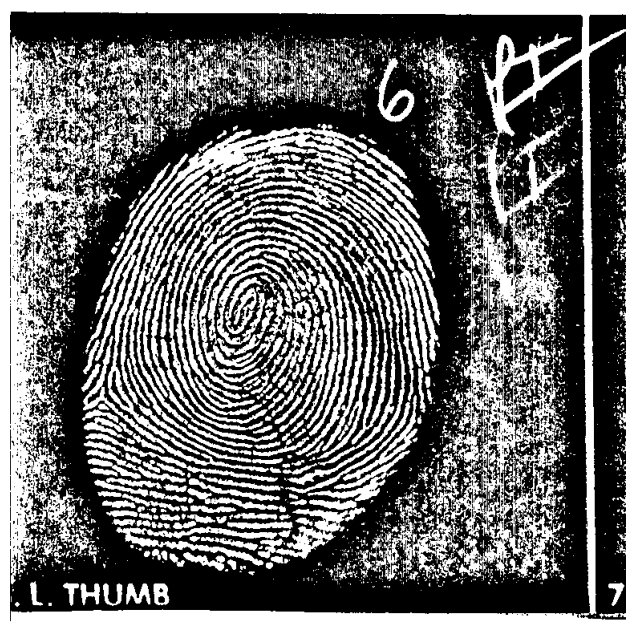

In [91]:
#eq = imgeq(img)
adaptive_g = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV,133,0)
cvlib.imgview(adaptive_g)

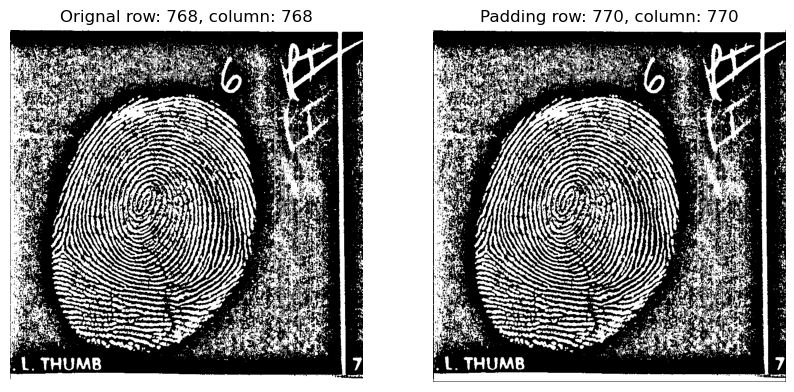

In [92]:
def imgpad(image, r):
    """_summary_
        La función empieza obteniendo el valor de columnas y filas de la imagen original. 
        Eso nos sirve, porque el padding es agregar un "marco" a la imagen, por lo que sabemos que
        r * 2 nos generara los espacios necesarios para el nuevo lenght de cada fila de la imagen. 
                                                                                    filas       columnas
        Por lo tanto, se crea un array con np.zero de numpy y sus dimensiones son: (row+(r*2), column+(r*2)
        Por ejemplo, si la imagen es de 8 * 8, tendremos una de 10 * 10, para tener 1 pixel de marco con el padding. 
        
        Para poner la imagen dentro de la matriz, le caemos encima a el espacio que equivale a donde estaría la imagen
        original. Eso nos trae justamente el espacio en donde corresponde nuestra imagen inicial. 
    Args:
        image (uint8): array de la imagen
        r (int): cantidad de pixeles que queremos nuestro padding. 
    """
    row,column = image.shape[0:2]
    arr = np.zeros((row+(r*2), column+(r*2)))
    arr[r:r+row, r:r+column] = image
    return arr

img2 = imgpad(adaptive_g, 1)
r,c = img.shape[0:2]
r2,c2 = img2.shape[0:2]
cvlib.imgcmp(adaptive_g, img2, title=['Orignal row: {0}, column: {1}'.format(r,c),'Padding row: {0}, column: {1}'.format(r2,c2)])

In [93]:
def find(data, i):
    if i != data[i]:
        data[i] = find(data, data[i])
    return data[i]

def union(data, i, j):
    pi, pj = find(data, i), find(data, j)
    if pi != pj:
        data[pj] = pi

def connected(data, i, j):
    return find(data, i) == find(data, j)

In [94]:
def connected_c(img):
    # first_pass
    current_pixel = 1
    conflictos = []
    labels_current = []
    copy_image = img.copy()
    copy_image[copy_image>0] = 1
    copy_image = imgpad(copy_image, 1)
    row, column = copy_image.shape[0:2]
    for r in range(row):
        for c in range(column):
                if (copy_image[r,c] != 0):
                    vecinos = [copy_image[r,c-1], copy_image[r-1,c]]
                    #print(vecinos)
                    if (vecinos[0] == 0 and vecinos[1] == 0):
                        copy_image[r,c] = int(current_pixel)
                        labels_current.append(current_pixel-1)
                        current_pixel += 1
                        #print(f"NO hay izquierda ni arriba, en pos: {r,c}")
                    else: 
                        if (vecinos[0] != 0 and vecinos[1] != 0):
                            if (vecinos[0] == vecinos[1]):
                                copy_image[r,c] = int(vecinos[0])
                            else:
                                copy_image[r,c] = int(min(vecinos))
                                if [int(min(vecinos)), int(max(vecinos))] in conflictos:
                                    pass
                                else:
                                    conflictos.append((int(min(vecinos))-1, int(max(vecinos))-1))
                                # crear relacion
                        elif(vecinos[0] == 0):
                             copy_image[r,c] = int(vecinos[1])
                        else:
                             copy_image[r,c] = int(vecinos[0])
    conflictos = list(set(conflictos))
    for i, j in conflictos:
        union(labels_current, i, j)
    copy_image = copy_image.astype(int)
    # two_pass
    for r in range(row):
        for c in range(column):
                if (copy_image[r,c] != 0):
                    copy_image[r,c] = (find(labels_current, (copy_image[r,c]-1)))+1
                    
    #print(labels_current)
    #labels_current = [i + value for i in labels_current]
    return copy_image, conflictos, labels_current

img_ccl, conflictos, labels_current = connected_c(adaptive_g)

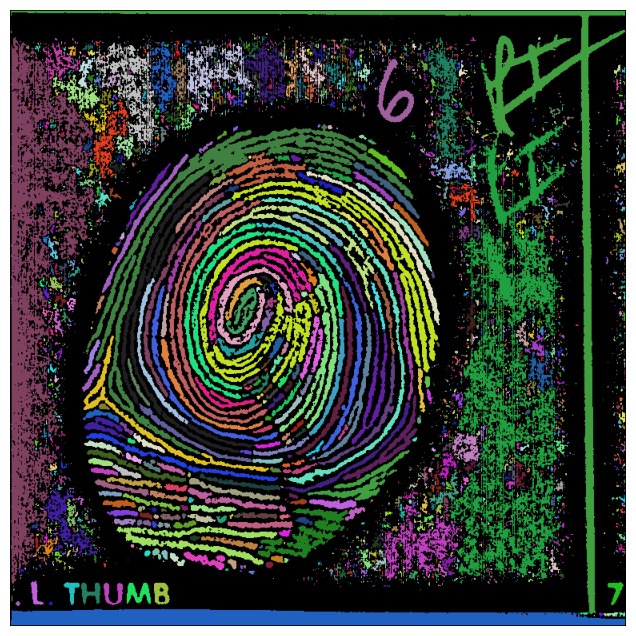

In [95]:
def random_color():
    levels = range(32,256,32)
    return tuple(random.choice(levels) for _ in range(3))
def labelview(labels):
    colores = {}
    row, column = labels.shape[0:2]
    img_color =  np.zeros(labels.shape, dtype=np.uint8)
    img_color = cv.cvtColor(img_color, cv.COLOR_GRAY2RGB)
    lista_is = list(set(labels_current))
    for i in [i + 1 for i in lista_is]:
        colores[i] = random_color()
    for r in range(row):
        for c in range(column):
            if (labels[r,c] != 0):
                img_color[r,c] = colores[labels[r,c]]
    cvlib.imgview(img_color)
    
labelview(img_ccl)